In [1]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers, losses, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
rc['font.size']=12
import random
from tensorflow import keras
from time import time

/opt/anaconda3/envs/eliz/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/eliz/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

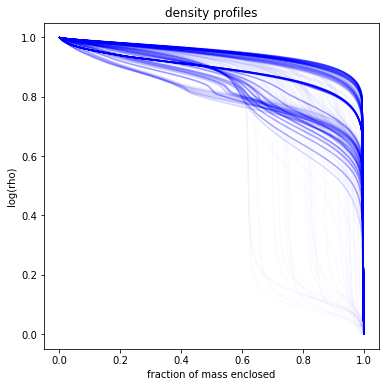

In [2]:
# dataset format:  m1, m2, p, final mass, normalized mass_enc profile,
#  central log(temperature), scaled temperature profile
data1 = np.load("../data/normalized_logrho_profiles.npy",allow_pickle=True)
valid = np.load("../data/normalized_logrho_validation_profiles.npy", allow_pickle=True)
random.seed(10)
data = random.sample(list(data1), 5000)

m1 = np.array([prof.get('m1') for prof in data], dtype='f') # initial stellar mass
m2 = np.array([prof.get('m2') for prof in data], dtype='f')
p = np.array([prof.get('p') for prof in data], dtype='f') # initial orbital period
linear_x = np.array(np.transpose([m1,m2,p]),dtype='f')

x = np.log10(linear_x) # 3d inputs for NN

linear_final_mass = np.array([prof.get('final_mass') for prof in data],dtype="f") # final stellar mass
final_mass = np.log10(linear_final_mass)

rho_min = np.array([prof.get('min_logrho') for prof in data], dtype='f')
rho_max = np.array([prof.get('max_logrho') for prof in data], dtype='f')

mass_points = data[0].get('m_arr') # x-values for normalized profiles

rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in data], dtype='f')

# scaled density profiles
prof_true = np.array([prof.get('logrho_arr') for prof in data],dtype='f')

# plotting the density data (first 1000)
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("density profiles")
plt.show()

In [3]:
valid_m1 = np.array([prof.get('m1') for prof in valid], dtype='f') # initial stellar mass
valid_m2 = np.array([prof.get('m2') for prof in valid], dtype='f')
valid_p = np.array([prof.get('p') for prof in valid], dtype='f') # initial orbital period
valid_linear_x = np.array(np.transpose([valid_m1,valid_m2,valid_p]),dtype='f')

valid_x = np.log10(valid_linear_x) # 3d inputs for NN

valid_linear_final_mass = np.array([prof.get('final_mass') for prof in valid],dtype="f") # final stellar mass
valid_final_mass = np.log10(valid_linear_final_mass)

valid_rho_min = np.array([prof.get('min_logrho') for prof in valid], dtype='f')
valid_rho_max = np.array([prof.get('max_logrho') for prof in valid], dtype='f')

valid_mass_points = valid[0].get('m_arr') # x-values for normalized profiles

valid_rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in valid], dtype='f')

# scaled density profiles
valid_prof_true = np.array([prof.get('logrho_arr') for prof in valid],dtype='f')

In [4]:
# VALIDATION
valid_pca = PCA(n_components=6).fit(valid_prof_true) # training PCA
valid_prof_low_unscaled = valid_pca.transform(valid_prof_true) # PCA weights 

# scaling factor: st dev of each component
valid_sc = np.std(valid_prof_low_unscaled,axis=0)
valid_prof_low = valid_prof_low_unscaled/valid_sc # scaled pca weights: 6-d NN outputs
valid_reconst = valid_pca.inverse_transform(valid_prof_low*valid_sc) # PCA reconstructed data

# plt.figure()
# plt.ylabel('% Variance Explained by PCA')
# plt.xlabel('# of Features')
# plt.title('PCA Variance')
# plt.ylim(86,100)
# plt.plot(np.arange(1,len(valid_pca.components_)+1),\
#          np.cumsum(valid_pca.explained_variance_ratio_)*100)
# plt.grid()

# plt.show()

# colors = plt.cm.viridis(np.linspace(0,1,len(valid_pca.components_)))
# plt.figure()
# for i in range(len(valid_pca.components_)):
#     plt.plot(valid_mass_points,valid_pca.components_[i]+0.2*i,c=colors[i])
# plt.xlabel("fraction of mass enclosed")
# plt.ylabel("log(rho)+offset")
# plt.title("principal components of dataset")
# plt.show()

# plt.figure(figsize=(6,6))
# for i in range(1000):
#     plt.plot(valid_mass_points,valid_prof_true[i],alpha=0.02,c='b')
#     plt.plot(valid_mass_points,valid_reconst[i],alpha=0.02,c='r')
# plt.xlabel("fraction of mass enclosed")
# plt.ylabel("log(rho)")
# plt.title("PCA-reconstructed (red) vs true (blue) density profiles")
# plt.show()

Next, I reshape and reduce dimensionality of the 200-d temperature profile outputs using PCA sphering. I only use the first 6 principal components, which explain ~99% of the variance between the set of original profiles and their PCA reconstructions (as the plot below shows)

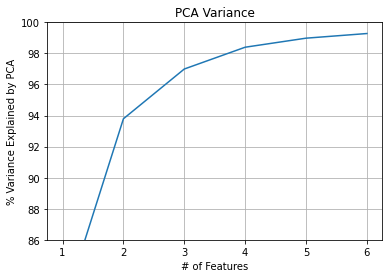

In [5]:
pca = PCA(n_components=6).fit(prof_true) # training PCA

plt.figure()
plt.ylabel('% Variance Explained by PCA')
plt.xlabel('# of Features')
plt.title('PCA Variance')
plt.ylim(86,100)
plt.plot(np.arange(1,len(pca.components_)+1),\
         np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid()

plt.show()

# colors = plt.cm.viridis(np.linspace(0,1,len(pca.components_)))
# plt.figure()
# for i in range(len(pca.components_)):
#     plt.plot(mass_points,pca.components_[i]+0.2*i,c=colors[i])
# plt.xlabel("fraction of mass enclosed")
# plt.ylabel("log(rho)+offset")
# plt.title("principal components of dataset")
# plt.show()

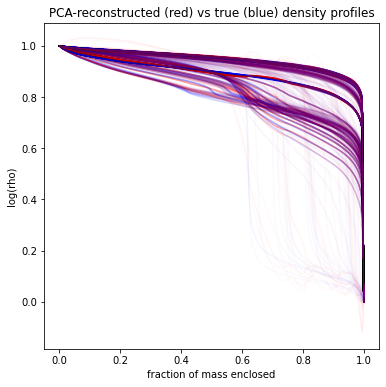

In [6]:
prof_low_unscaled = pca.transform(prof_true) # PCA weights 

# scaling factor: st dev of each component
sc = np.std(prof_low_unscaled,axis=0)
prof_low = prof_low_unscaled/sc # scaled pca weights: 6-d NN outputs
reconst = pca.inverse_transform(prof_low*sc) # PCA reconstructed data

# plotting for the first 1000 points out of 38000 because it gets too cluttered
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
    plt.plot(mass_points,reconst[i],alpha=0.02,c='r')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("PCA-reconstructed (red) vs true (blue) density profiles")
plt.show()

In [7]:
# Comparing true profiles to reconstructed profiles
# for i in range(30):
#     plt.plot(mass_points,prof_true[i])
#     plt.plot(mass_points, reconst[i])
#     plt.ylabel(i)
#     plt.show()
    
# 12 components gives a nearly identical reconstruction
# 6 components is a bit worse but still good, with slight deviations

My neural network consists of 6 fully-connected layers, with 2 inputs for the initial stellar mass and initial orbital periods, 
and 6 outputs. I use the Adam optimizer on a mean squared error loss function.

In [8]:
model = models.Sequential([
    layers.Dense(15,input_dim=3,activation=None),
    layers.Dense(15,input_dim=15,activation="relu"),
    layers.Dense(15,input_dim=15,activation="relu"),
    layers.Dense(15,input_dim=15,activation="tanh"),
    layers.Dense(10,input_dim=10,activation="tanh"),
    layers.Dense(10,input_dim=10,activation="tanh"),
    layers.Dense(6,input_dim=10,activation=None)
])

regress = lambda x: model(x)

2022-12-05 10:09:33.620556: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 10:09:33.621004: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [9]:
prof_low_pred = regress(x)
loss_mse = losses.MeanSquaredError()
loss_mse(prof_low,prof_low_pred).numpy()

1.0430636

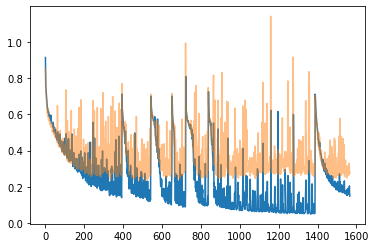

time: 849.3014540672302


In [10]:
t0 = time()
model.compile(optimizers.Adam(clipnorm=1),loss=loss_mse,lr=0.0001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)
history = model.fit(x,prof_low,epochs=3000,callbacks=[callback],verbose=0, validation_data=(valid_x, valid_prof_low))
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"],alpha=0.5)
plt.show()
print("time:",time()-t0)

In [13]:
prof_low_pred = regress(x)
loss_mse = losses.MeanSquaredError()
loss_mse(prof_low,prof_low_pred).numpy()

0.13843542

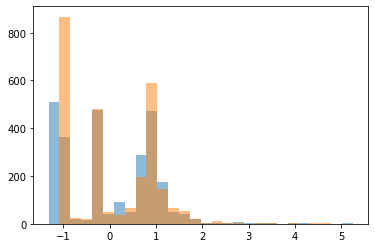

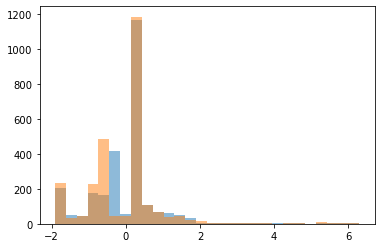

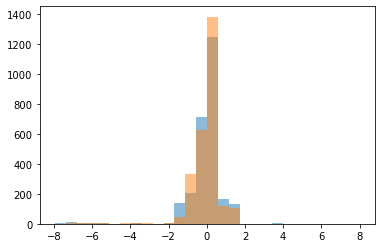

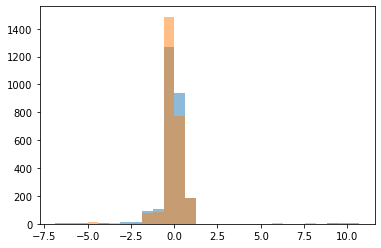

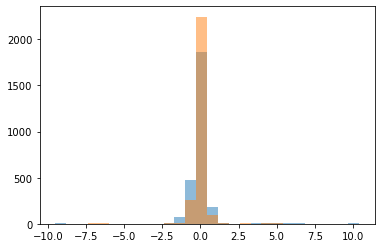

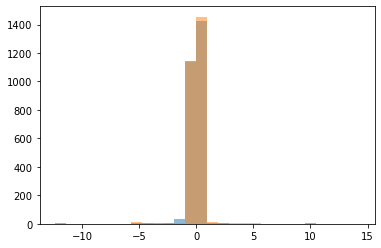

In [106]:
for i in range(6):
    plt.figure()
    low = np.min(valid_prof_low[:,i])
    high = np.max(valid_prof_low[:,i])
    num=29
    plt.hist(valid_prof_low[:,i],alpha=0.5,bins=np.linspace(low, high,num))
    plt.hist(model(valid_x).numpy()[:,i],alpha=0.5,bins=np.linspace(low, high,num))
    plt.show()

# final mass

In [61]:
# model to predict final mass - 3 inputs, 1 output
model_mass = models.Sequential([
    layers.Dense(10,input_dim=3,activation=None),
    layers.Dense(10,input_dim=10,activation='relu'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(1,activation=None)
])

regress_mass = lambda x: model_mass(x)


mpred = regress_mass(x)

loss_mse = losses.MeanSquaredError()
loss_mape = losses.MeanAbsolutePercentageError()
loss_mse(final_mass,mpred).numpy()
#loss_mape(final_mass,mpred).numpy()

0.81622535

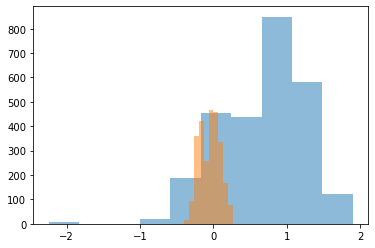

In [62]:
plt.figure()
plt.hist(valid_final_mass,alpha=0.5)
plt.hist(model_mass(valid_x).numpy(),alpha=0.5)
plt.show()

Train on 5000 samples, validate on 2656 samples
Epoch 1/2000
5000/5000 [==============================] - 2s 319us/sample - loss: 0.1721 - val_loss: 0.0275
Epoch 2/2000
5000/5000 [==============================] - 1s 104us/sample - loss: 0.0190 - val_loss: 0.0186
Epoch 3/2000
5000/5000 [==============================] - 1s 108us/sample - loss: 0.0147 - val_loss: 0.0169
Epoch 4/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0130 - val_loss: 0.0158
Epoch 5/2000
5000/5000 [==============================] - 1s 104us/sample - loss: 0.0122 - val_loss: 0.0142
Epoch 6/2000
5000/5000 [==============================] - 1s 107us/sample - loss: 0.0121 - val_loss: 0.0131
Epoch 7/2000
5000/5000 [==============================] - 1s 103us/sample - loss: 0.0113 - val_loss: 0.0132
Epoch 8/2000
5000/5000 [==============================] - 1s 109us/sample - loss: 0.0114 - val_loss: 0.0130
Epoch 9/2000
5000/5000 [==============================] - 1s 108us/sample - loss: 0.0111

Epoch 76/2000
5000/5000 [==============================] - 1s 159us/sample - loss: 0.0059 - val_loss: 0.0077
Epoch 77/2000
5000/5000 [==============================] - 1s 153us/sample - loss: 0.0058 - val_loss: 0.0064
Epoch 78/2000
5000/5000 [==============================] - 1s 171us/sample - loss: 0.0068 - val_loss: 0.0056
Epoch 79/2000
5000/5000 [==============================] - 1s 201us/sample - loss: 0.0057 - val_loss: 0.0064
Epoch 80/2000
5000/5000 [==============================] - 1s 238us/sample - loss: 0.0067 - val_loss: 0.0058
Epoch 81/2000
5000/5000 [==============================] - 1s 200us/sample - loss: 0.0056 - val_loss: 0.0052
Epoch 82/2000
5000/5000 [==============================] - 1s 172us/sample - loss: 0.0058 - val_loss: 0.0049
Epoch 83/2000
5000/5000 [==============================] - 1s 118us/sample - loss: 0.0057 - val_loss: 0.0066
Epoch 84/2000
5000/5000 [==============================] - 1s 114us/sample - loss: 0.0059 - val_loss: 0.0077
Epoch 85/2000
5000/

Epoch 151/2000
5000/5000 [==============================] - 1s 105us/sample - loss: 0.0031 - val_loss: 0.0040
Epoch 152/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0049 - val_loss: 0.0090
Epoch 153/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0051 - val_loss: 0.0041
Epoch 154/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0036 - val_loss: 0.0058
Epoch 155/2000
5000/5000 [==============================] - 1s 115us/sample - loss: 0.0040 - val_loss: 0.0035
Epoch 156/2000
5000/5000 [==============================] - 1s 118us/sample - loss: 0.0026 - val_loss: 0.0051
Epoch 157/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0042 - val_loss: 0.0051
Epoch 158/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0036 - val_loss: 0.0038
Epoch 159/2000
5000/5000 [==============================] - 1s 100us/sample - loss: 0.0030 - val_loss: 0.0070
Epoch 160/200

5000/5000 [==============================] - 1s 101us/sample - loss: 0.0038 - val_loss: 0.0040
Epoch 226/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 0.0024 - val_loss: 0.0029
Epoch 227/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 0.0029 - val_loss: 0.0035
Epoch 228/2000
5000/5000 [==============================] - 1s 118us/sample - loss: 0.0024 - val_loss: 0.0044
Epoch 229/2000
5000/5000 [==============================] - 1s 137us/sample - loss: 0.0038 - val_loss: 0.0037
Epoch 230/2000
5000/5000 [==============================] - 1s 178us/sample - loss: 0.0031 - val_loss: 0.0067
Epoch 231/2000
5000/5000 [==============================] - 1s 121us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 232/2000
5000/5000 [==============================] - 1s 118us/sample - loss: 0.0032 - val_loss: 0.0063
Epoch 233/2000
5000/5000 [==============================] - 1s 111us/sample - loss: 0.0022 - val_loss: 0.0031
Epoch 234/2000
5000/5000 

Epoch 300/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0022 - val_loss: 0.0034
Epoch 301/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0026 - val_loss: 0.0046
Epoch 302/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0022 - val_loss: 0.0034
Epoch 303/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 0.0028 - val_loss: 0.0029
Epoch 304/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0031 - val_loss: 0.0027
Epoch 305/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0021 - val_loss: 0.0038
Epoch 306/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0031 - val_loss: 0.0048
Epoch 307/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 308/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0025 - val_loss: 0.0034
Epoch 309/2000
5000

5000/5000 [==============================] - 0s 99us/sample - loss: 0.0051 - val_loss: 0.0059
Epoch 376/2000
5000/5000 [==============================] - 1s 100us/sample - loss: 0.0047 - val_loss: 0.0056
Epoch 377/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 0.0041 - val_loss: 0.0086
Epoch 378/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0042 - val_loss: 0.0056
Epoch 379/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0033 - val_loss: 0.0039
Epoch 380/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0037 - val_loss: 0.0050
Epoch 381/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 382/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0035 - val_loss: 0.0049
Epoch 383/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0030 - val_loss: 0.0052
Epoch 384/2000
5000/5000 [=======

5000/5000 [==============================] - 1s 100us/sample - loss: 0.0019 - val_loss: 0.0033
Epoch 451/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0022 - val_loss: 0.0033
Epoch 452/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0036 - val_loss: 0.0062
Epoch 453/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 454/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0035 - val_loss: 0.0050
Epoch 455/2000
5000/5000 [==============================] - 1s 120us/sample - loss: 0.0026 - val_loss: 0.0040
Epoch 456/2000
5000/5000 [==============================] - 1s 108us/sample - loss: 0.0034 - val_loss: 0.0024
Epoch 457/2000
5000/5000 [==============================] - 1s 103us/sample - loss: 0.0029 - val_loss: 0.0038
Epoch 458/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0020 - val_loss: 0.0065
Epoch 459/2000
5000/5000 [=

5000/5000 [==============================] - 1s 146us/sample - loss: 0.0013 - val_loss: 0.0023
Epoch 525/2000
5000/5000 [==============================] - 1s 145us/sample - loss: 0.0015 - val_loss: 0.0030
Epoch 526/2000
5000/5000 [==============================] - 1s 113us/sample - loss: 0.0069 - val_loss: 0.0061
Epoch 527/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0022 - val_loss: 0.0033
Epoch 528/2000
5000/5000 [==============================] - 1s 108us/sample - loss: 0.0028 - val_loss: 0.0034
Epoch 529/2000
5000/5000 [==============================] - 1s 132us/sample - loss: 0.0018 - val_loss: 0.0027
Epoch 530/2000
5000/5000 [==============================] - 1s 153us/sample - loss: 0.0019 - val_loss: 0.0031
Epoch 531/2000
5000/5000 [==============================] - 1s 107us/sample - loss: 0.0034 - val_loss: 0.0029
Epoch 532/2000
5000/5000 [==============================] - 1s 111us/sample - loss: 0.0021 - val_loss: 0.0041
Epoch 533/2000
5000/5000 

5000/5000 [==============================] - 1s 117us/sample - loss: 0.0016 - val_loss: 0.0036
Epoch 599/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0039 - val_loss: 0.0041
Epoch 600/2000
5000/5000 [==============================] - 1s 107us/sample - loss: 0.0018 - val_loss: 0.0027
Epoch 601/2000
5000/5000 [==============================] - 1s 107us/sample - loss: 0.0017 - val_loss: 0.0028
Epoch 602/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0014 - val_loss: 0.0023
Epoch 603/2000
5000/5000 [==============================] - 1s 112us/sample - loss: 0.0018 - val_loss: 0.0027
Epoch 604/2000
5000/5000 [==============================] - 1s 111us/sample - loss: 0.0015 - val_loss: 0.0030
Epoch 605/2000
5000/5000 [==============================] - 1s 108us/sample - loss: 0.0011 - val_loss: 0.0019
Epoch 606/2000
5000/5000 [==============================] - 1s 116us/sample - loss: 0.0014 - val_loss: 0.0030
Epoch 607/2000
5000/5000 [

5000/5000 [==============================] - 1s 157us/sample - loss: 8.8185e-04 - val_loss: 0.0030
Epoch 673/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 0.0041 - val_loss: 0.0052
Epoch 674/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0012 - val_loss: 0.0048
Epoch 675/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0011 - val_loss: 0.0023
Epoch 676/2000
5000/5000 [==============================] - 1s 100us/sample - loss: 0.0010 - val_loss: 0.0029
Epoch 677/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0057 - val_loss: 0.0060
Epoch 678/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0049 - val_loss: 0.0051
Epoch 679/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0035 - val_loss: 0.0043
Epoch 680/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0033 - val_loss: 0.0037
Epoch 681/2000
5000/5000 [=

5000/5000 [==============================] - 1s 101us/sample - loss: 0.0037 - val_loss: 0.0039
Epoch 747/2000
5000/5000 [==============================] - 1s 103us/sample - loss: 0.0056 - val_loss: 0.0080
Epoch 748/2000
5000/5000 [==============================] - 1s 111us/sample - loss: 0.0038 - val_loss: 0.0046
Epoch 749/2000
5000/5000 [==============================] - 1s 120us/sample - loss: 0.0023 - val_loss: 0.0028
Epoch 750/2000
5000/5000 [==============================] - 1s 111us/sample - loss: 0.0017 - val_loss: 0.0050
Epoch 751/2000
5000/5000 [==============================] - 1s 114us/sample - loss: 0.0018 - val_loss: 0.0033
Epoch 752/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0018 - val_loss: 0.0020
Epoch 753/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0025 - val_loss: 0.0037
Epoch 754/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0013 - val_loss: 0.0019
Epoch 755/2000
5000/5000 

5000/5000 [==============================] - 1s 102us/sample - loss: 0.0046 - val_loss: 0.0036
Epoch 821/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0021 - val_loss: 0.0030
Epoch 822/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0015 - val_loss: 0.0021
Epoch 823/2000
5000/5000 [==============================] - 1s 112us/sample - loss: 9.8185e-04 - val_loss: 0.0024
Epoch 824/2000
5000/5000 [==============================] - 1s 139us/sample - loss: 8.0126e-04 - val_loss: 0.0037
Epoch 825/2000
5000/5000 [==============================] - 1s 159us/sample - loss: 9.9133e-04 - val_loss: 0.0047
Epoch 826/2000
5000/5000 [==============================] - 1s 131us/sample - loss: 0.0031 - val_loss: 0.0034
Epoch 827/2000
5000/5000 [==============================] - 1s 139us/sample - loss: 0.0026 - val_loss: 0.0024
Epoch 828/2000
5000/5000 [==============================] - 1s 131us/sample - loss: 0.0017 - val_loss: 0.0023
Epoch 829/200

Epoch 894/2000
5000/5000 [==============================] - 1s 103us/sample - loss: 0.0037 - val_loss: 0.0046
Epoch 895/2000
5000/5000 [==============================] - 1s 100us/sample - loss: 0.0033 - val_loss: 0.0040
Epoch 896/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0028 - val_loss: 0.0043
Epoch 897/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0027 - val_loss: 0.0033
Epoch 898/2000
5000/5000 [==============================] - 1s 100us/sample - loss: 0.0027 - val_loss: 0.0039
Epoch 899/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0023 - val_loss: 0.0031
Epoch 900/2000
5000/5000 [==============================] - 1s 104us/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 901/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 0.0037 - val_loss: 0.0039
Epoch 902/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0029 - val_loss: 0.0049
Epoch 903/2000

5000/5000 [==============================] - 1s 105us/sample - loss: 0.0025 - val_loss: 0.0028
Epoch 969/2000
5000/5000 [==============================] - 1s 104us/sample - loss: 0.0026 - val_loss: 0.0028
Epoch 970/2000
5000/5000 [==============================] - 1s 107us/sample - loss: 0.0021 - val_loss: 0.0034
Epoch 971/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 0.0020 - val_loss: 0.0026
Epoch 972/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0016 - val_loss: 0.0030
Epoch 973/2000
5000/5000 [==============================] - 1s 103us/sample - loss: 0.0023 - val_loss: 0.0035
Epoch 974/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0018 - val_loss: 0.0027
Epoch 975/2000
5000/5000 [==============================] - 1s 103us/sample - loss: 0.0019 - val_loss: 0.0041
Epoch 976/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0016 - val_loss: 0.0020
Epoch 977/2000
5000/5000 

5000/5000 [==============================] - 1s 104us/sample - loss: 0.0013 - val_loss: 0.0026
Epoch 1042/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 7.6622e-04 - val_loss: 0.0018
Epoch 1043/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 6.7767e-04 - val_loss: 0.0023
Epoch 1044/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 8.4543e-04 - val_loss: 0.0017
Epoch 1045/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 7.1641e-04 - val_loss: 0.0017
Epoch 1046/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 7.4929e-04 - val_loss: 0.0020
Epoch 1047/2000
5000/5000 [==============================] - 1s 106us/sample - loss: 0.0013 - val_loss: 0.0037
Epoch 1048/2000
5000/5000 [==============================] - 1s 107us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 1049/2000
5000/5000 [==============================] - 1s 116us/sample - loss: 0.0024 - val_loss: 0.0023

Epoch 1114/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 9.1789e-04 - val_loss: 0.0016
Epoch 1115/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0011 - val_loss: 0.0020
Epoch 1116/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 8.3462e-04 - val_loss: 0.0028
Epoch 1117/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 9.9104e-04 - val_loss: 0.0019
Epoch 1118/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 8.3284e-04 - val_loss: 0.0015
Epoch 1119/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0010 - val_loss: 0.0018
Epoch 1120/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 7.6996e-04 - val_loss: 0.0017
Epoch 1121/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 9.0150e-04 - val_loss: 0.0014
Epoch 1122/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 8.5597e-04 

5000/5000 [==============================] - 0s 97us/sample - loss: 0.0036 - val_loss: 0.0045
Epoch 1188/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0034 - val_loss: 0.0039
Epoch 1189/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0032 - val_loss: 0.0048
Epoch 1190/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0029 - val_loss: 0.0040
Epoch 1191/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0035 - val_loss: 0.0043
Epoch 1192/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 0.0027 - val_loss: 0.0036
Epoch 1193/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0028 - val_loss: 0.0036
Epoch 1194/2000
5000/5000 [==============================] - 0s 96us/sample - loss: 0.0023 - val_loss: 0.0042
Epoch 1195/2000
5000/5000 [==============================] - 1s 102us/sample - loss: 0.0026 - val_loss: 0.0040
Epoch 1196/2000
5000/5000

5000/5000 [==============================] - 1s 101us/sample - loss: 0.0014 - val_loss: 0.0033
Epoch 1262/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0013 - val_loss: 0.0021
Epoch 1263/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0014 - val_loss: 0.0024
Epoch 1264/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0014 - val_loss: 0.0024
Epoch 1265/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0016 - val_loss: 0.0034
Epoch 1266/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0015 - val_loss: 0.0021
Epoch 1267/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0015 - val_loss: 0.0031
Epoch 1268/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0016 - val_loss: 0.0024
Epoch 1269/2000
5000/5000 [==============================] - 0s 97us/sample - loss: 0.0015 - val_loss: 0.0022
Epoch 1270/2000
5000/5000

5000/5000 [==============================] - 1s 100us/sample - loss: 0.0036 - val_loss: 0.0068
Epoch 1336/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0040 - val_loss: 0.0031
Epoch 1337/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0019 - val_loss: 0.0028
Epoch 1338/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0016 - val_loss: 0.0023
Epoch 1339/2000
5000/5000 [==============================] - 1s 101us/sample - loss: 0.0016 - val_loss: 0.0024
Epoch 1340/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0016 - val_loss: 0.0026
Epoch 1341/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0018 - val_loss: 0.0061
Epoch 1342/2000
5000/5000 [==============================] - 0s 99us/sample - loss: 0.0026 - val_loss: 0.0037
Epoch 1343/2000
5000/5000 [==============================] - 0s 98us/sample - loss: 0.0017 - val_loss: 0.0032
Epoch 1344/2000
5000/500

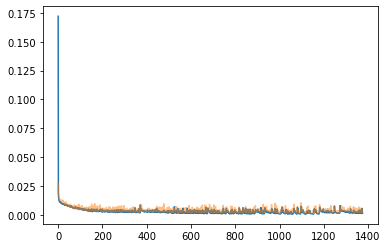

5000/1 - 0s - loss: 6.8001e-04
time 748.1875307559967


In [63]:
t0 = time()
model_mass.compile(optimizers.Adam(clipnorm=1),loss=loss_mse,lr=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
history = model_mass.fit(x,final_mass,epochs=2000,\
                         callbacks=[callback],verbose=1,\
                        validation_data =(valid_x,valid_final_mass))
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"],alpha=0.5)
plt.show()

print("time",time()-t0)
model_mass.evaluate(x,final_mass,verbose=2)

In [105]:
model_mass.evaluate(x,final_mass,verbose=2)

5000/1 - 0s - loss: 6.8001e-04


0.0012984879049705341

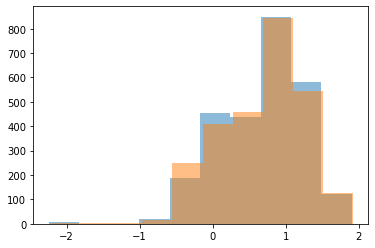

In [64]:
plt.hist(valid_final_mass,alpha=0.5,bins=10)
plt.hist(model_mass(valid_x).numpy(),alpha=0.5,bins=10)
plt.show()

# min/max density

In [55]:
# 3 inputs and 2 outputs (min/max logrho)
model_rho = models.Sequential([
    layers.Dense(10,input_dim=3,activation='relu'),
    layers.Dense(10,input_dim=10,activation='relu'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(10,input_dim=10,activation='tanh'),
    layers.Dense(2,activation=None)
])

regress_rho = lambda x: model_rho(x)

rhopred = regress_rho(x)

loss_mse = losses.MeanSquaredError()
loss_mse(rho_minmax,rhopred).numpy()

40.93567

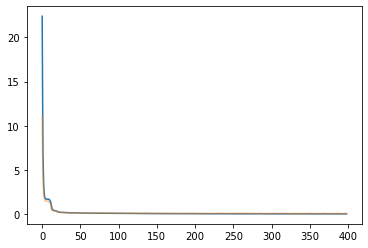

5000/1 - 0s - loss: 0.0255
time: 219.65992403030396


In [56]:
t0 = time()
model_rho.compile(optimizers.Adam(clipnorm=1),loss="mse")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
history = model_rho.fit(x,rho_minmax,epochs=2000,\
                         callbacks=[callback],verbose=0,
                       validation_data =(valid_x,valid_rho_minmax))
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"],alpha=0.5)
plt.show()

model_rho.evaluate(x,rho_minmax,verbose=2)
print("time:",time()-t0)

# profile predictions

My final prediction brings together all 3 NNs to reconstruct the temperature profile prediction for any new binary in this 2d slice of parameter space. 

In [57]:
def pred_profiles(lin_x):
    x = np.log10(lin_x)
    final_log_masses = regress_mass(x).numpy()
    final_linear_masses = 10**final_log_masses
    
    min_rho = np.array(regress_rho(x)[:,0])
    max_rho = np.array(regress_rho(x)[:,1])
    
    scaled_pca_weights = regress(x)
    norm_profiles = pca.inverse_transform(scaled_pca_weights*sc)
    
    density_profiles = norm_profiles*(max_rho[:,np.newaxis]-min_rho[:,np.newaxis]) + min_rho[:,np.newaxis]
    xcoords = mass_points*final_linear_masses[:,np.newaxis]

    return xcoords,density_profiles

In [58]:
def eval_model(i):
    testpts = [valid_linear_x[i]]
    xcoords, profiles = pred_profiles(testpts)
    
    true_x = mass_points*valid_linear_final_mass[i]
    true_y = valid_prof_true[i]*(valid_rho_max[i]-valid_rho_min[i])+valid_rho_min[i]
    
    plt.figure(figsize=(9,7))
    plt.plot(true_x, true_y, label="true")
    plt.plot(xcoords[0][0],profiles[0],label="pred")
    plt.xlabel("mass enclosed, solar masses")
    plt.ylabel("predicted log(rho profile)")
    plt.title("NN-predicted density profiles for validation profile "+str(i))
    plt.legend()
    plt.show()


2


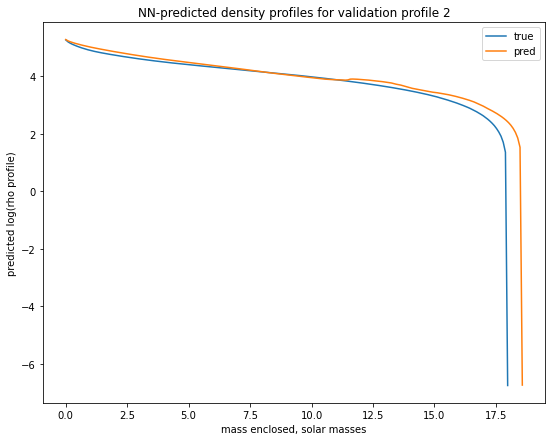

3


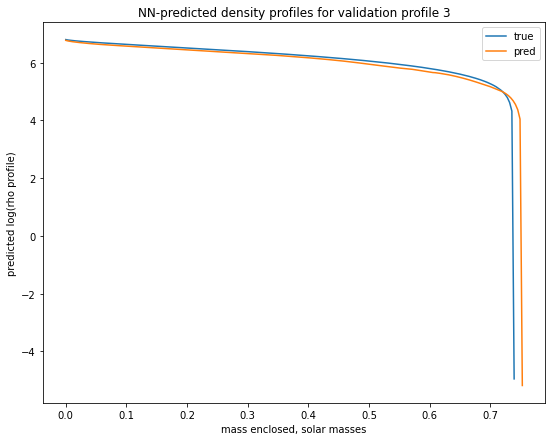

100


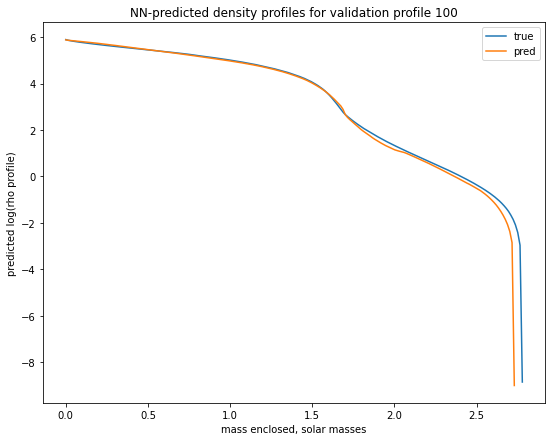

200


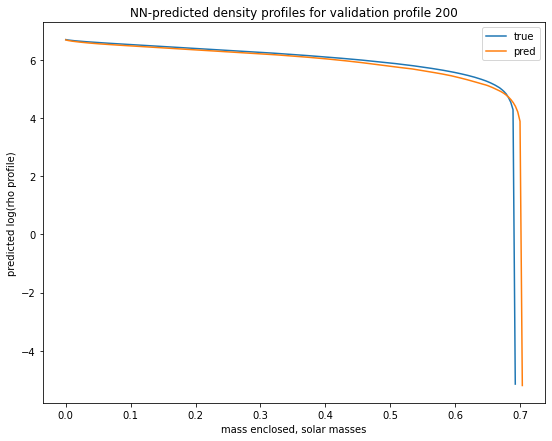

300


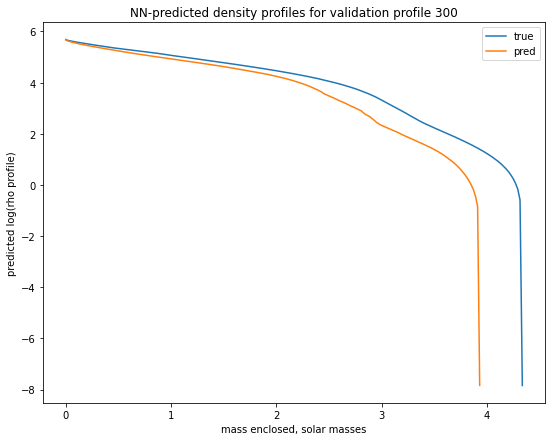

350


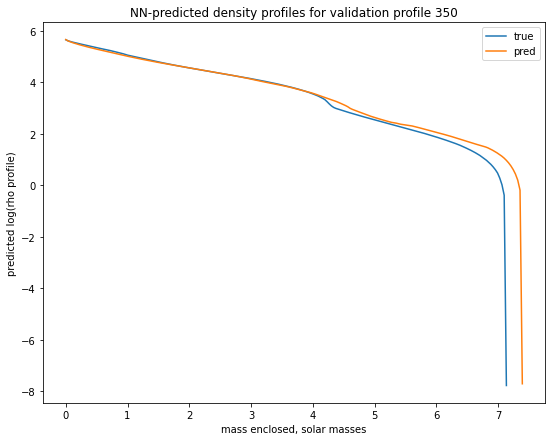

351


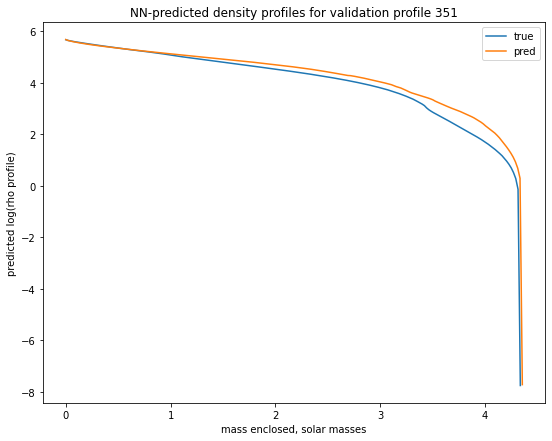

2000


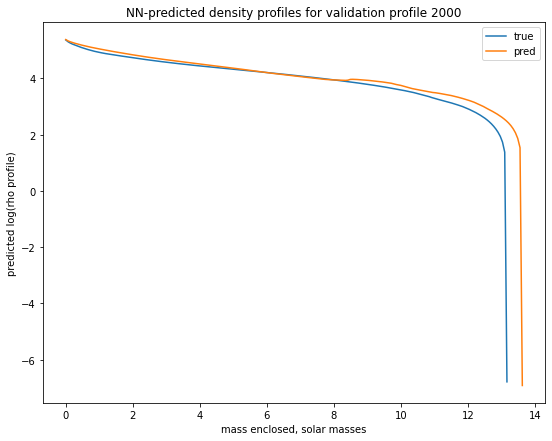

In [65]:
# mse
for i in [2,3,100,200,300,350,351,2000]:
    print(i)
    eval_model(i)

## next steps

model evaluation

compare different predictions a la Monica

ask which profiles are most important

temperature

more infrastructure

isolated networks plus one network for correlations

fine tune final mass model

2


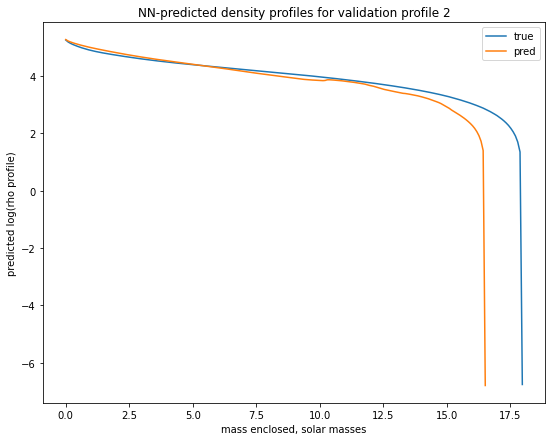

3


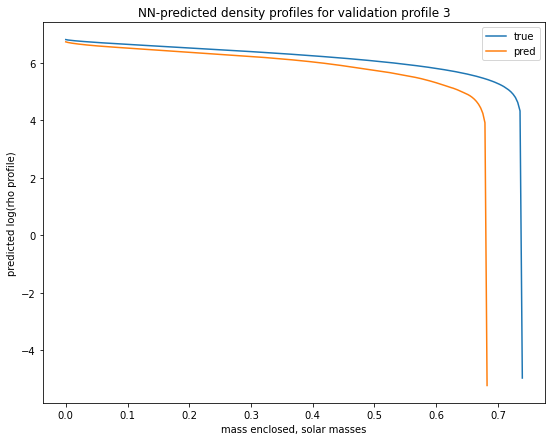

100


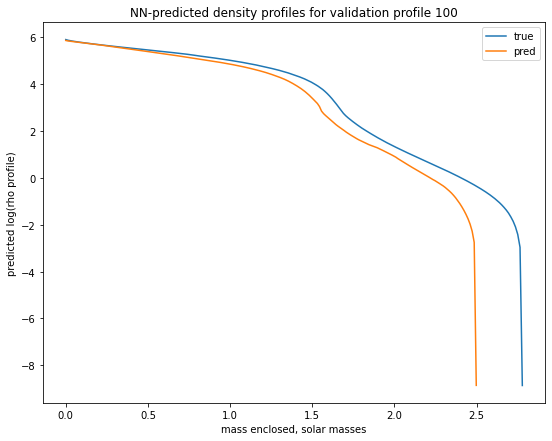

200


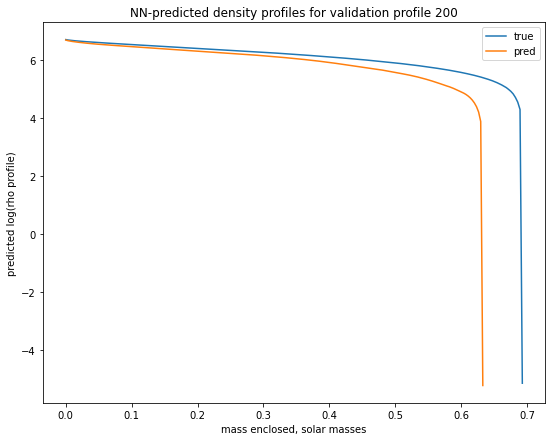

300


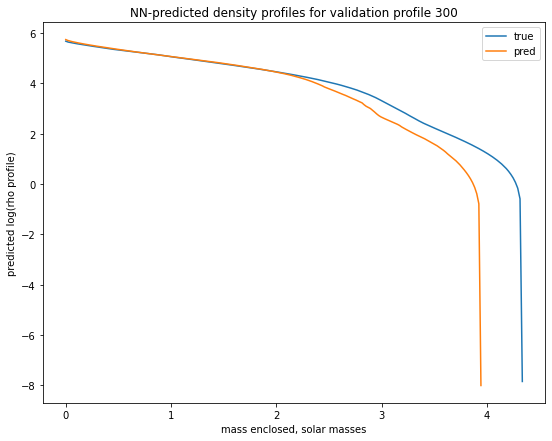

350


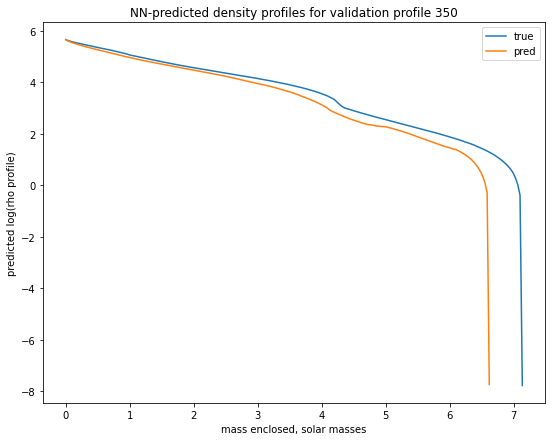

351


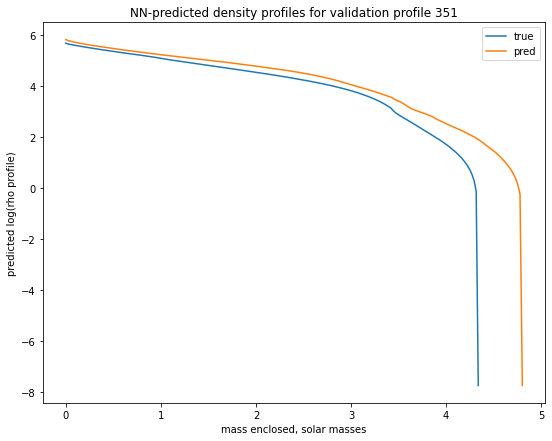

2000


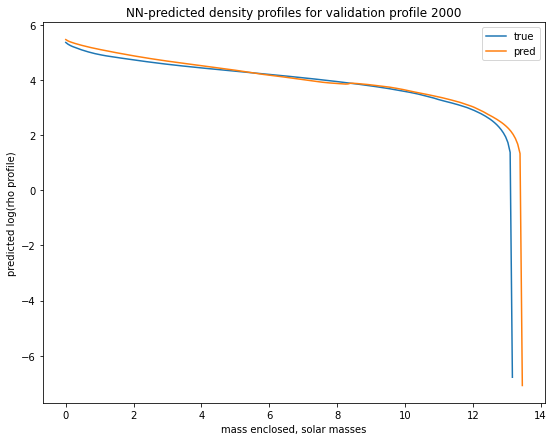

In [71]:
# mape
for i in [2,3,100,200,300,350,351,2000]:
    print(i)
    eval_model(i)